In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Set device and seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# 3. Dataset paths
base_path = "/content/drive/MyDrive/curl_types_cropped_split 2"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

In [ ]:
# 4. Load datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# 5. Load pre-trained model
model = models.efficientnet_b2(pretrained=True)
num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

model = model.to(device)

# Only train the classifier initially
optimizer_classifier = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

initial_epochs = 5 # Train only classifier for a few epochs
for epoch in range(initial_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_classifier.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_classifier.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / len(train_dataset)
    print(f"Initial Classifier Training - Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

# Now freeze the base layers
for param in model.features.parameters():
    param.requires_grad = False

# Update optimizer to train all trainable parameters (just the classifier now)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 125MB/s]


Initial Classifier Training - Epoch 1, Train Loss: 23.6301, Train Acc: 40.50%
Initial Classifier Training - Epoch 2, Train Loss: 20.0990, Train Acc: 56.27%
Initial Classifier Training - Epoch 3, Train Loss: 18.1160, Train Acc: 66.67%
Initial Classifier Training - Epoch 4, Train Loss: 16.7965, Train Acc: 71.33%
Initial Classifier Training - Epoch 5, Train Loss: 16.1073, Train Acc: 69.89%


In [ ]:
for param in model.features[-5:].parameters():  # unfreeze last 5 blocks
    param.requires_grad = True

In [ ]:
# 6. Loss, optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# 7. Training loop with early stopping
best_val_loss = np.inf
patience = 5
epochs_no_improve = 0
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / len(train_dataset)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / len(val_dataset)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

Epoch 1, Train Loss: 19.6519, Train Acc: 62.01%
Val Loss: 3.4901, Val Acc: 73.33%
Epoch 2, Train Loss: 16.0417, Train Acc: 71.33%
Val Loss: 3.0350, Val Acc: 76.67%
Epoch 3, Train Loss: 16.0802, Train Acc: 70.25%
Val Loss: 3.3696, Val Acc: 71.67%
Epoch 4, Train Loss: 16.3989, Train Acc: 68.10%
Val Loss: 3.6082, Val Acc: 71.67%
Epoch 5, Train Loss: 14.7184, Train Acc: 72.76%
Val Loss: 3.5401, Val Acc: 73.33%
Epoch 6, Train Loss: 15.8062, Train Acc: 72.76%
Val Loss: 3.2576, Val Acc: 80.00%
Epoch 7, Train Loss: 13.7458, Train Acc: 78.14%
Val Loss: 2.9315, Val Acc: 80.00%
Epoch 8, Train Loss: 14.3282, Train Acc: 75.27%
Val Loss: 3.4032, Val Acc: 75.00%
Epoch 9, Train Loss: 13.1890, Train Acc: 81.72%
Val Loss: 3.2325, Val Acc: 75.00%
Epoch 10, Train Loss: 13.6210, Train Acc: 79.93%
Val Loss: 2.8176, Val Acc: 80.00%
Epoch 11, Train Loss: 13.0402, Train Acc: 81.36%
Val Loss: 2.6172, Val Acc: 83.33%
Epoch 12, Train Loss: 11.5928, Train Acc: 85.66%
Val Loss: 3.0154, Val Acc: 76.67%
Epoch 13, Tra

In [ ]:
# 8. Load best model and evaluate
model.load_state_dict(torch.load("best_model.pth"))

def evaluate_model(loader, dataset_name):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / len(loader.dataset)
    print(f"{dataset_name} Accuracy: {accuracy:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes, cmap='Blues')
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Validation Accuracy: 83.33%


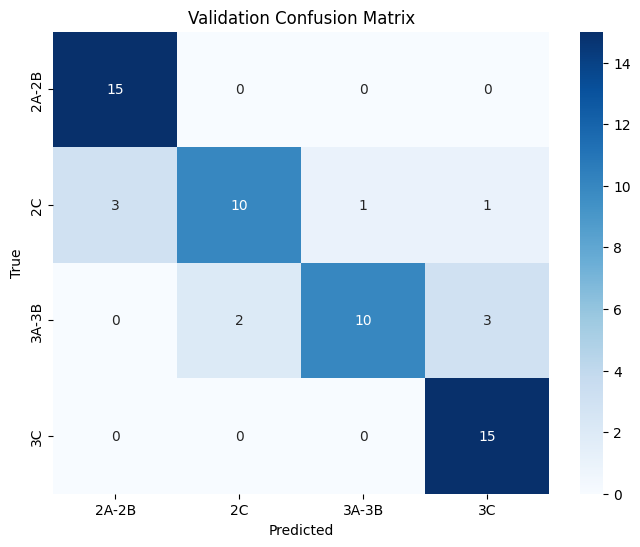

Test Accuracy: 81.67%


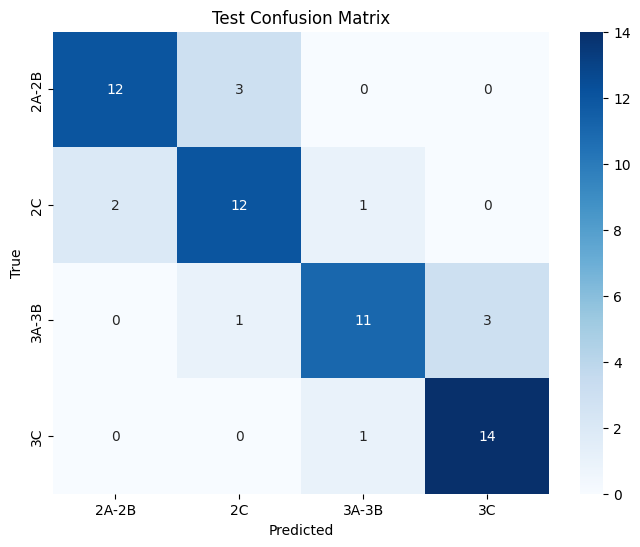

In [ ]:
# 9. Final evaluations
evaluate_model(val_loader, "Validation")
evaluate_model(test_loader, "Test")

In [ ]:
from google.colab import files
files.download("best_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>